In [1]:
import speckle
from speckle.inference.read_in_data import *
from speckle.inference.correlation_heatmap import *
from speckle.inference.calculating_tau import *
from speckle.inference.dedrift import *

In [2]:
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
import numpy as np
from scipy.optimize import curve_fit
import math
from operator import itemgetter

In [3]:
def spatial_correlation(example_img, sp_shape,ROI):
    y_length=example_img.shape[0]
    x_length=example_img.shape[1]
    num_pixels=y_length*x_length
    spcorrelation_map = np.zeros((sp_shape,sp_shape))
    for dy in range(-math.floor(sp_shape/2), math.floor(sp_shape/2), 1):
        for dx in range(-math.floor(sp_shape/2), math.floor(sp_shape/2), 1):
            sum_numerator=0
            sum_denum_1=0
            sum_denum_2=0
            count=0
            for y in range(ROI[0],ROI[0]+ROI[2],1):
                for x in range(ROI[1],ROI[1]+ROI[3],1):
                    sum_numerator+=int(example_img[y][x])*int(example_img[y+dy][x+dx])
                    sum_denum_1+=int(example_img[y][x])
                    sum_denum_2+=int(example_img[y+dy][x+dx])
                    count+=1
            numerator=sum_numerator/count
            denum_1=sum_denum_1/count
            denum_2=sum_denum_2/count
            spcorrelation_map[dy+math.floor(sp_shape/2)][dx+math.floor(sp_shape/2)]=copy.deepcopy(numerator/(denum_1*denum_2)-1)
    normalization=spcorrelation_map[math.floor(sp_shape/2)][math.floor(sp_shape/2)]
    spcorrelation_map=spcorrelation_map/normalization
    sns.heatmap(spcorrelation_map)
    return spcorrelation_map

In [4]:
def plot_spmap_x_direction(spcorrelation_map):
    x_radius=np.arange(-spcorrelation_map.shape[0]/2,spcorrelation_map.shape[0]/2,1)
    radius_squared=x_radius**2
    spcorrelation_map_x=np.array(spcorrelation_map)[int(spcorrelation_map.shape[0]/2)][:]
    
    plt.plot(radius_squared,spcorrelation_map_x,'.')
    #plt.xlim(0,10)
    plt.legend(['Correlation vs delta r'], fontsize=18)
    plt.xlabel("delta r [pixels]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.show

In [5]:
def calculate_speckle_size_x_direction_try(spcorrelation_map,startidx,endidx,plotBoolean=True):
    x_radius=np.arange(-spcorrelation_map.shape[0]/2,spcorrelation_map.shape[0]/2,1)
    radius_squared=x_radius**2
    spcorrelation_map_x=spcorrelation_map[int(spcorrelation_map.shape[0]/2)][:]
    plateau=spcorrelation_map_x[-1]
    if plateau>0.05 or plateau<0:
        log_correlation=np.log(abs(spcorrelation_map_x-plateau))
    else:
        log_correlation=np.log(abs(spcorrelation_map_x))
    combined_list=[]
    combined_list.append(radius_squared)
    combined_list.append(log_correlation)
    combined_list=np.array(combined_list)
    combined_list_sorted=np.array(sorted(combined_list.transpose(),key=lambda lst:lst[1],reverse=True)).transpose()
    if plotBoolean==True:
        x, y = combined_list_sorted[0][startidx:endidx], combined_list_sorted[1][startidx:endidx]
        # curve fit
        popt, _ = curve_fit(objective_try, x, y)
        # summarize the parameter values
        a,b= popt
        print("speckle size is:",np.sqrt(-1/a))
        print('y = %.5f * x' % (a))
        # plot input vs output
        plt.scatter(x, y)
        
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(min(x), max(x), 1)
        # calculate the output for the range
        y_line = objective_try(x_line, a,b)
        # create a line plot for the mapping function
        plt.plot(x_line, y_line, '--', color='red')
        plt.show()
        return np.sqrt(-1/a),a,b
    else:
        x, y = combined_list_sorted[0][0:20], combined_list_sorted[1][0:20]
        # curve fit
        popt, _ = curve_fit(objective_try, x, y)
        # summarize the parameter values
        a,b= popt
        return np.sqrt(-1/a)

def objective_try(x, a,b):
	return a * x+b

In [6]:
def reconstruct_curve_x_direction_try(spcorrelation_map,a,b,):
    x_radius=np.arange(-spcorrelation_map.shape[0]/2,spcorrelation_map.shape[0]/2,1)
    radius_squared=x_radius**2
    spcorrelation_map_x=np.array(spcorrelation_map)[int(spcorrelation_map.shape[0]/2)][:]
    plateau=spcorrelation_map_x[-1]
        
    y=np.zeros(len(radius_squared))
    for i in range(0, len(radius_squared),1):
        y[i]=(math.exp(a*radius_squared[i]))*math.exp(b)
    if plateau>0.05 or plateau<0:
        y=y+plateau
    plt.figure(figsize=(8,5))
    plt.plot(radius_squared,y,'*',label="fit line")
    plt.plot(radius_squared,spcorrelation_map_x,'.',label="data")
    plt.legend(['Correlation vs Delta r'], fontsize=18)
    plt.xlabel("Delta r [pixel]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.legend(fontsize=18)
    plt.tick_params(direction='in')

# 0.05% 100 nm 10x objective 0.67 au

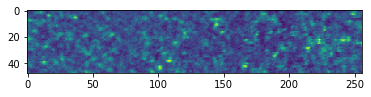

In [8]:
imgname='0p05percentwt_100nm_inglycerol_1min_0p67au_10x_obj_50umdepth_15magnification'
foldername='/Volumes/wwyyrx/Wenyun/20220718/analysis/'
img=read_in_data(foldername,imgname)

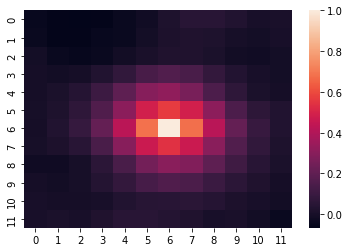

In [9]:
img=img[300]
ROI=[7,10,19,230] #y,x,h,w
sp_shape=12
spmap=spatial_correlation(img,sp_shape,ROI)

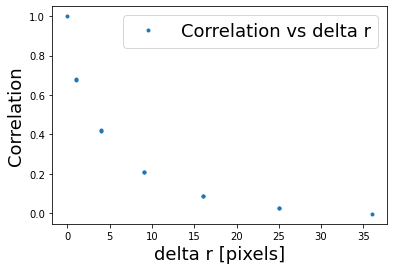

In [10]:
plot_spmap_x_direction(spmap)

speckle size is: 2.628567354829444
y = -0.14473 * x


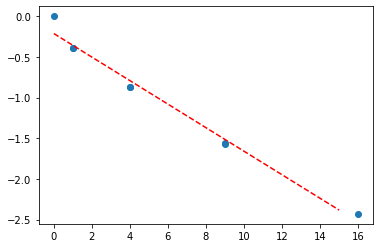

In [15]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,0,8)

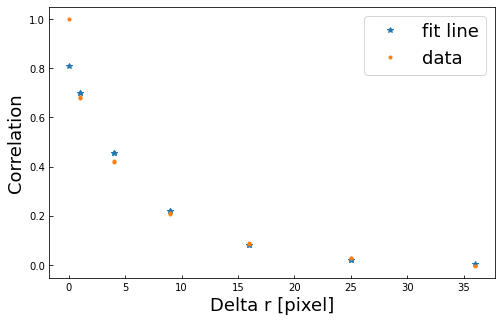

In [16]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [17]:
scale= 4.5255
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.628567354829444 pixel
The size is :0.5808346823178531 um


# 0.05% 100 nm 10x objective 1 au

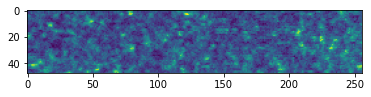

In [18]:
imgname='0p05percentwt_100nm_inglycerol_1min_1au_10x_obj_50umdepth_15magnification'
foldername='/Volumes/wwyyrx/Wenyun/20220718/analysis/'
img=read_in_data(foldername,imgname)

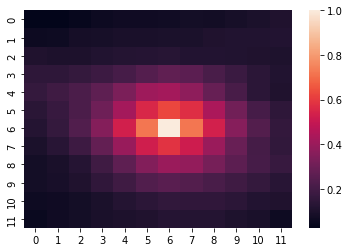

In [19]:
img=img[300]
ROI=[7,10,19,230] #y,x,h,w
sp_shape=12
spmap=spatial_correlation(img,sp_shape,ROI)

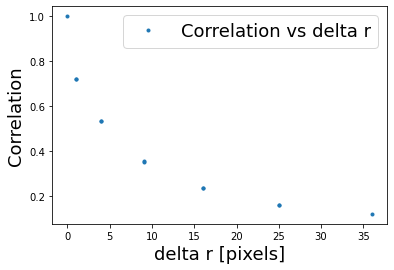

In [20]:
plot_spmap_x_direction(spmap)

speckle size is: 2.6867134365528846
y = -0.13853 * x


/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/ipykernel_26546/1732939080.py:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


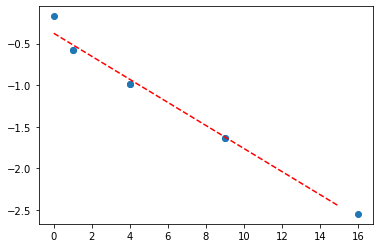

In [26]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,0,8)

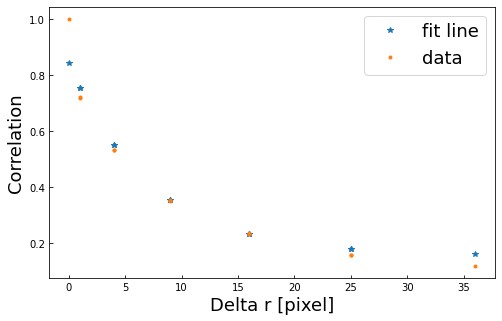

In [27]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [28]:
scale= 4.5255
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.6867134365528846 pixel
The size is :0.5936832254011456 um


# 0.05% 100 nm 10x objective 2.02 au

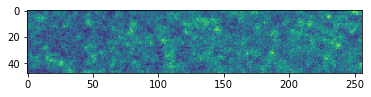

In [48]:
imgname='0p05percentwt_100nm_inglycerol_1min_2p02au_10x_obj_50umdepth_15magnification'
foldername='/Volumes/wwyyrx/Wenyun/20220718/analysis/'
img=read_in_data(foldername,imgname)

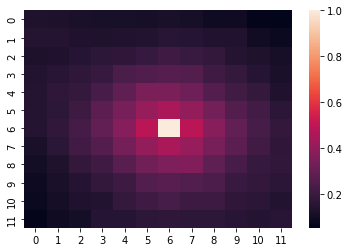

In [49]:
img=img[600]
ROI=[7,10,19,230] #y,x,h,w
sp_shape=12
spmap=spatial_correlation(img,sp_shape,ROI)

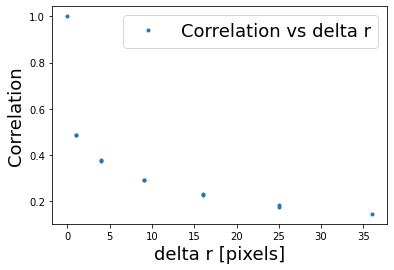

In [50]:
plot_spmap_x_direction(spmap)

speckle size is: 2.7879253617628144
y = -0.12866 * x


/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/ipykernel_26546/1732939080.py:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


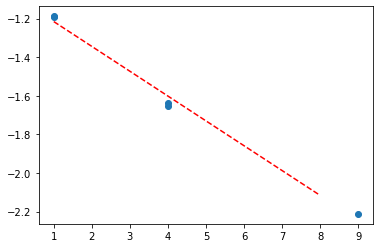

In [61]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,1,6)

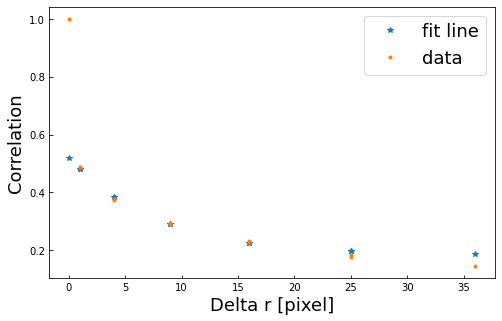

In [62]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [63]:
scale= 4.5255
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.7879253617628144 pixel
The size is :0.6160480304414572 um


# 0.05% 100 nm 20x objective 0.79 au

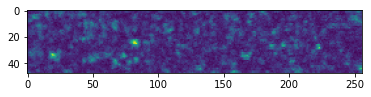

In [64]:
imgname='0p05percentwt_100nm_inglycerol_1min_0p79au_20x_obj_60umdepth_15magnification'
foldername='/Volumes/wwyyrx/Wenyun/20220718/analysis/'
img=read_in_data(foldername,imgname)

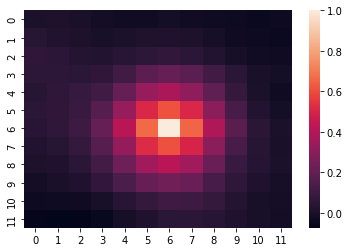

In [65]:
img=img[600]
ROI=[7,10,19,230] #y,x,h,w
sp_shape=12
spmap=spatial_correlation(img,sp_shape,ROI)

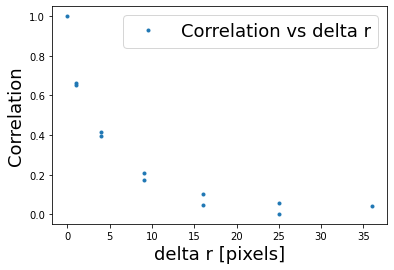

In [66]:
plot_spmap_x_direction(spmap)

speckle size is: 2.6402258369154157
y = -0.14346 * x


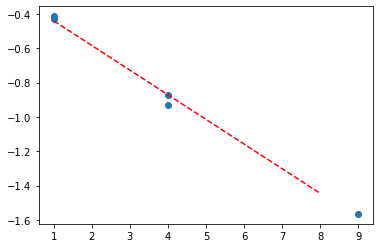

In [67]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,1,6)

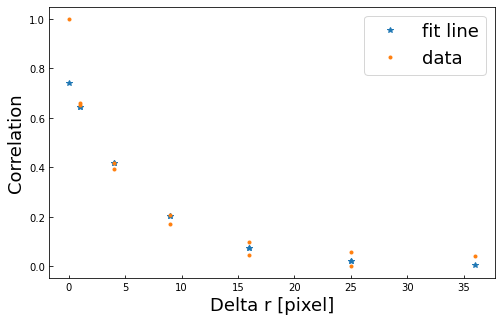

In [68]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [69]:
scale= 9.0590
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.6402258369154157 pixel
The size is :0.2914478239226643 um


# 0.05% 100 nm 20x objective 1 au

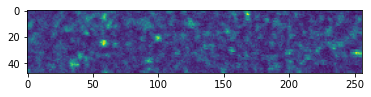

In [70]:
imgname='0p05percentwt_100nm_inglycerol_1min_1au_20x_obj_60umdepth_15magnification'
foldername='/Volumes/wwyyrx/Wenyun/20220718/analysis/'
img=read_in_data(foldername,imgname)

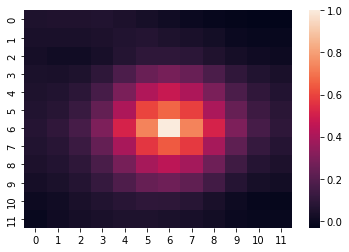

In [71]:
img=img[600]
ROI=[7,10,19,230] #y,x,h,w
sp_shape=12
spmap=spatial_correlation(img,sp_shape,ROI)

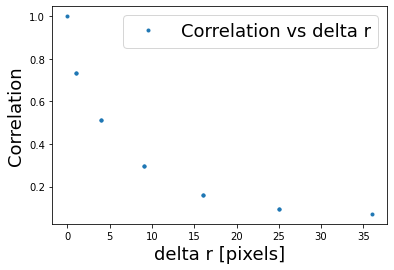

In [72]:
plot_spmap_x_direction(spmap)

speckle size is: 2.6383468767089426
y = -0.14366 * x


/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/ipykernel_26546/1732939080.py:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


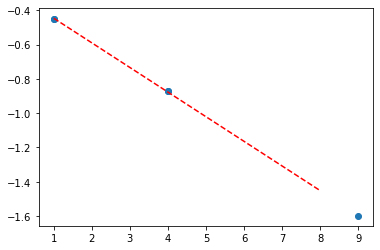

In [73]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,1,6)

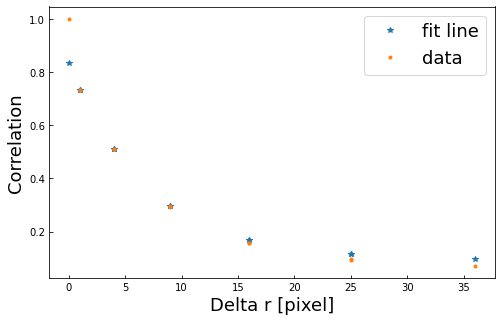

In [74]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [75]:
scale= 9.0590
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.6383468767089426 pixel
The size is :0.2912404102780597 um


# 0.05% 100 nm 20x objective 2.03 au

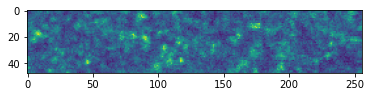

In [76]:
imgname='0p05percentwt_100nm_inglycerol_1min_2p03au_20x_obj_60umdepth_15magnification'
foldername='/Volumes/wwyyrx/Wenyun/20220718/analysis/'
img=read_in_data(foldername,imgname)

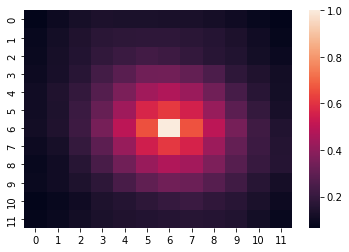

In [77]:
img=img[600]
ROI=[7,10,19,230] #y,x,h,w
sp_shape=12
spmap=spatial_correlation(img,sp_shape,ROI)

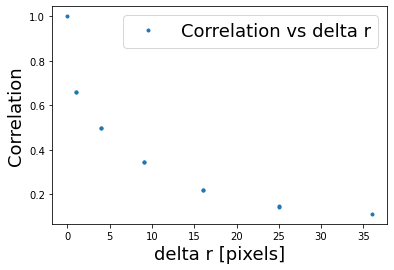

In [78]:
plot_spmap_x_direction(spmap)

speckle size is: 2.9026275507992
y = -0.11869 * x


/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/ipykernel_26546/1732939080.py:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


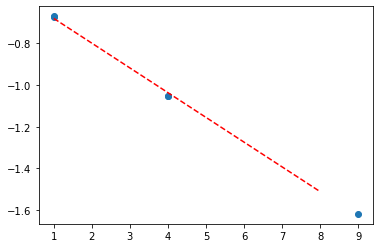

In [79]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,1,6)

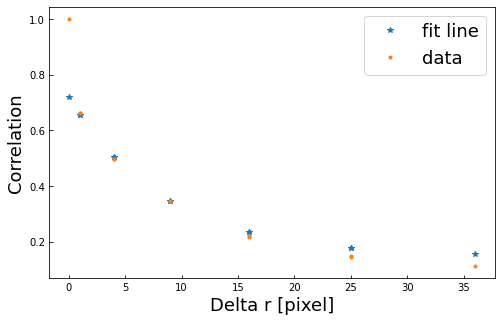

In [80]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [81]:
scale= 9.0590
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.9026275507992 pixel
The size is :0.32041368261388675 um


# 0.05% 100 nm 40x water objective 0.63 au

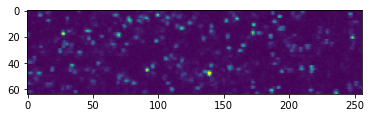

In [100]:
imgname='0p05percentwt_100nm_inglycerol_1min_0p63au_40xw_obj_60umdepth'
foldername='/Volumes/wwyyrx/Wenyun/20220718/analysis/'
img=read_in_data(foldername,imgname)

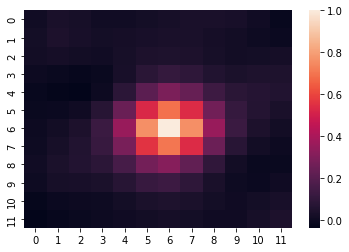

In [101]:
img=img[600]
ROI=[7,10,19,230] #y,x,h,w
sp_shape=12
spmap=spatial_correlation(img,sp_shape,ROI)

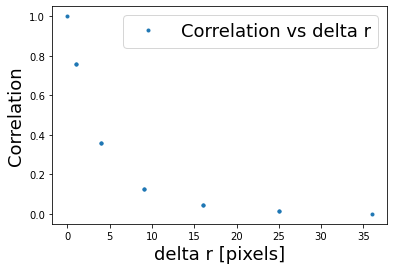

In [102]:
plot_spmap_x_direction(spmap)

speckle size is: 2.101531538693747
y = -0.22643 * x


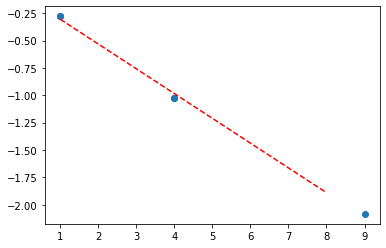

In [103]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,1,6)

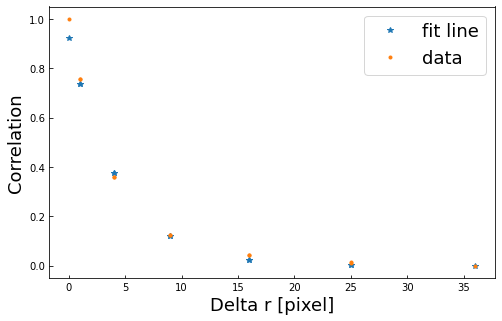

In [104]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [105]:
scale= 12.0679
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.101531538693747 pixel
The size is :0.17414227319531542 um


# 0.05% 100 nm 40x water objective 1 au

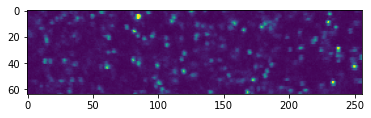

In [106]:
imgname='0p05percentwt_100nm_inglycerol_1min_1au_40xw_obj_60umdepth'
foldername='/Volumes/wwyyrx/Wenyun/20220718/analysis/'
img=read_in_data(foldername,imgname)

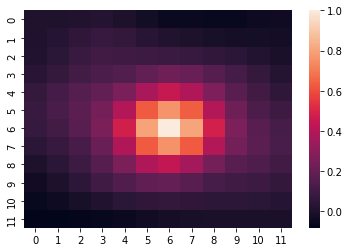

In [107]:
img=img[600]
ROI=[7,10,19,230] #y,x,h,w
sp_shape=12
spmap=spatial_correlation(img,sp_shape,ROI)

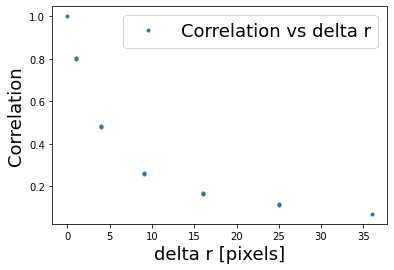

In [108]:
plot_spmap_x_direction(spmap)

speckle size is: 2.2679689670489163
y = -0.19441 * x


/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/ipykernel_26546/1732939080.py:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


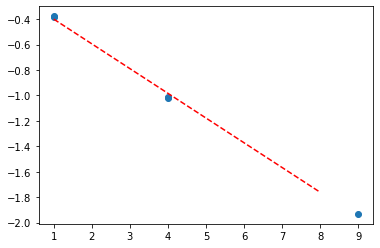

In [109]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,1,6)

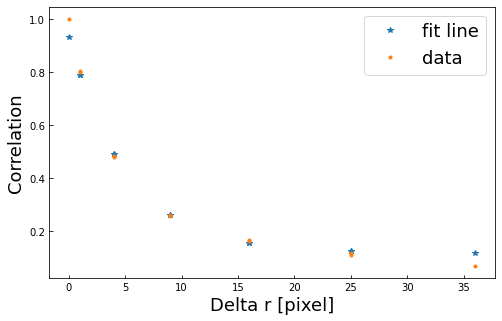

In [110]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [111]:
scale= 12.0679
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.2679689670489163 pixel
The size is :0.18793402058758493 um


# 0.05% 100 nm 40x water objective 1.77 au

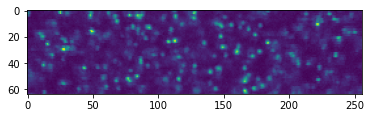

In [112]:
imgname='0p05percentwt_100nm_inglycerol_1min_1p77au_40xw_obj_60umdepth'
foldername='/Volumes/wwyyrx/Wenyun/20220718/analysis/'
img=read_in_data(foldername,imgname)

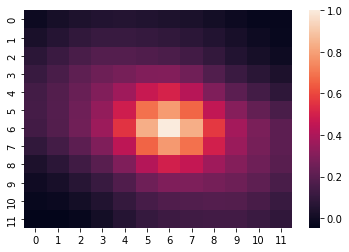

In [113]:
img=img[600]
ROI=[7,10,19,230] #y,x,h,w
sp_shape=12
spmap=spatial_correlation(img,sp_shape,ROI)

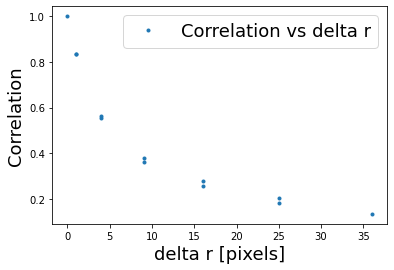

In [114]:
plot_spmap_x_direction(spmap)

speckle size is: 2.48744175251266
y = -0.16162 * x


/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/ipykernel_26546/1732939080.py:7: RuntimeWarning: divide by zero encountered in log
  log_correlation=np.log(abs(spcorrelation_map_x-plateau))


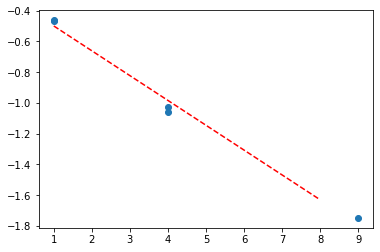

In [115]:
size,a,b=calculate_speckle_size_x_direction_try(spmap,1,6)

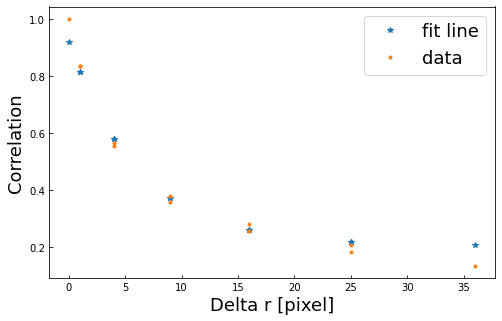

In [116]:
reconstruct_curve_x_direction_try(spmap,a,b)

In [117]:
scale= 12.0679
speckle_size=np.sqrt(-1/a)/scale
print('The size is :'+str(np.sqrt(-1/a))+' pixel')
print('The size is :'+str(speckle_size)+' um')

The size is :2.48744175251266 pixel
The size is :0.2061205141335825 um
